# プロセスの内容

ここでは実際にプログラムが動くプロセスについて説明します。  
C/C++は、コンパイルされたプログラムはそのままプロセスの仕組みに乗っかって動くので特に重要です。  
Javaも含めインタプリタ言語は、直接プロセスを意識することはありませんが、仕組みについてはある程度知っていた方が良いです。

## プロセスのメモリ構造

ソフトウェアの動作する仕組みとしてまずは押さえておきたいのがメモリ構造です。

プログラムの内容は、CPUが認識できる形式でメモリに展開され、CPUはそのメモリの内容に従って動きます。  
また、プログラムに必要なデータなどもメモリ上に展開されます。  
ファイルから読み込んだ内容、変数の内容、HTTP通信でクライアントから受信した内容、すべてがメモリ上に置かれます。  
そのメモリの内容を使ってCPUが処理し、メモリが不要になったら解放したり他の用途に使うなど、すべての処理においてメモリが重要となります。

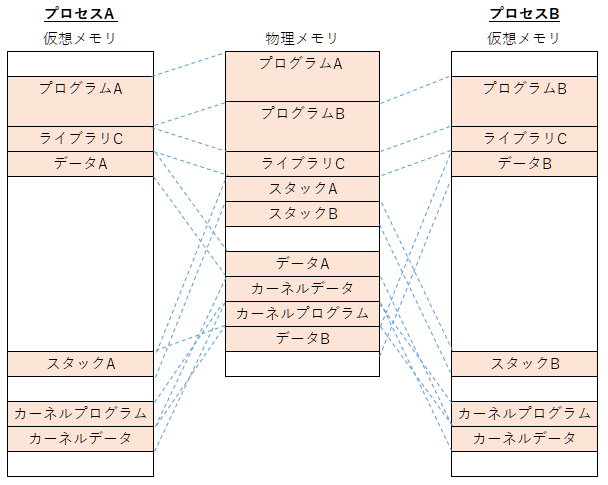

プロセスのメモリイメージを書きましたが、ポイントは以下です。

- プロセスごとに別の仮想メモリ空間を持っている
- 仮想メモリ空間はすべて埋まっているわけではなく飛び飛びとなっている
- 仮想メモリと物理メモリがマッピングされている
- 複数プロセスで共有の物理メモリを使っていることもある
- プロセスには、プログラム、データ、スタック領域がある
- ライブラリやカーネルも仮想メモリに展開される

### 一般的なメモリの機能

メモリがハードウェア的に持っている機能（メモリだけではなくCPUとの連携機能もある）として以下は知っておいて損はありません。  
これらは全ての種類のハードウェアで実現されているものではありませんが、このような機能が使える場合は概ね使っていると思います。

- メモリはページと呼ばれる単位（大体4KByte単位）で物理メモリと仮想メモリで対応付けられる
- メモリページごとに「読み取り専用」「書き込み可能」「実行可能（CPUが命令として実行しても良いメモリ）」という属性が付けられる
- カーネルモード/ユーザモードというCPUが持っている権限レベルに応じて、同じ仮想メモリ空間でもメモリの読み取り可否が変わる

CPUはメモリの内容を読み込んで命令を実行しますが、そのメモリの内容におかしな命令が記述されていると暴走してしまいます。  
例えば、メモリはデータの保存先としても使いますが、そこに保存されているデータは有効なCPU命令になっていないため、そのようなデータ部分をCPUが命令として実行しようとすると暴走します。

このような状況にならないように、実行権限のついたページしか実行できないような機構が存在しています。  
プロセスのメモリ構造でいうと、自作のプログラム部分やライブラリ・カーネル内のプログラム部分は実行権限があり、それ以外のデータやスタックなどは実行権限は基本的に付きません。  
またプログラムの実行権限が付いている部分は読み取り専用となっており、プログラムの命令を謝って書き換えて暴走するということも防いでいます。

このような読み取り専用部分に書き込もうとしたり、実行権限のないところを実行しようとすれば、メモリアクセスエラーが発生してコアダンプします。  
どのような動作になるか分からず暴走するよりは安全な停止方法です。

また、カーネルが管理しているデータは、ユーザが作成したプログラムから見えてはならないため、通常は読み取りも出来ないようになっています。  
ユーザプログラムからシステムコールを呼び出すことで、CPUがカーネルモードとなり、その間だけカーネル内のデータを読み書きできるようになります。  
このように、カーネルが持っているデータを安全に管理できるような仕組みになっています。

インタプリタ言語やJavaなどで、効率化のために実行時コンパイル（JIT：Just In Compile）によりCPU命令に展開することで速度を上げるものがあります。  
このように動的に作成できるメモリは、基本的にデータ領域となっており、通常は実行権限は付けられません。  
そのため、このような実行時コンパイルを実現するには、確保したデータ領域のメモリに実行権限を付けるような処理をする必要があります。

このようなメモリの機能をフル活用するようなプログラムを作ることは稀ですが、仕組みを知っていると解析の幅が広がります。

### ヒープとスタック

プロセスの仮想メモリの中には、プログラムの他に変数などの情報を保持するためのデータとスタック領域があります。  
また、データの中は、起動時から領域が確保されている初期データエリアと、処理に応じてメモリを確保するヒープエリアの2種類があります。  
C言語でいう malloc は、このヒープエリアを使ってメモリを確保します。

関数内のローカル変数（auto変数）や、関数の呼び出し履歴（スタックトレース）は、スタック領域に保存されます。  
スタックはスレッドごとに持っているため、マルチスレッドになるとスレッド数分のスタック領域が確保されます。

データ領域はスレッドごとではなく、プロセスとして管理されています。

よく「メモリリークしている」とか「プロセスが大量にメモリを使っている」などと言いますが、このほとんどの減員はヒープエリアが増え続けている状態です。  
このような状態が続くと、いずれ Out Of Memory になります。  
また、スタックオーバーフローは、スレッドに割り当てられた最大のスタック領域をオーバーした際に発生します。

ようするに、メモリの上限値には、ヒープとスタックという両側面があるということです。

### スワップ

プロセスの仮想メモリ空間は飛び飛びで全部使っているわけではありませんが、それでも物理メモリより多く確保する可能性があります。  
1プロセスだけでは物理メモリを超えなくても、全プロセスを合わせると物理メモリを超えるだけの仮想メモリが必要となることがあります。

その場合、あまり使われていないメモリページを、いったんディスクへ保存し、物理メモリの割り当てを解放するのがスワップです。

物理メモリが解放されたメモリページにアクセスすると、メモリアクセス不正の例外が発生しますが、それをカーネルが検知した際にディスクへスワップしている場合は、開いている物理メモリにディスクから読み込んで、仮想メモリへ再度割り当てます。  
もし空いている物理メモリがない場合は、よりアクセスの少ないメモリページをディスクへスワップしてから割り当てるかもしれません。

物理メモリがあまりに不足すると、このようなスワップが頻繁に発生して、よくアクセスするページすらスワップにいったり来たりすることで、極端に処理が遅くなります。

カーネルの実装次第ではありますが、スワップ対象がプログラム領域（しばらく動いていないモジュール部分とか）だった場合は、メモリイメージがディスクに保存されている実行ファイルイメージと同じであるため、物理メモリは解放するもののメモリページのコピーを新たにディスクに作らないかもしれません。  
再度メモリアクセスがあった場合は、メモリページに該当する内容を実行ファイルから読み込めばよいからです。

## プロセスが持っているリソース

メモリの次に大事とも言えるのが、プロセスが持っているリソースです。  
リソースという言葉だと漠然としているので、特に開発者として理解が必要と思われる以下について説明します。

- プロセスが開いているファイル数
- プロセスが利用しているソケット数
- プロセスで実行中のスレッド数

### ファイルディスクリプタ

Linux系では「ファイルディスクリプタ」と呼びますが、Windowsでは「Handle」とも呼びます。  
これは主に前述の以下を示します。

- プロセスが開いているファイル数
- プロセスが利用しているソケット数

プログラムが実行中は、マシン内のファイルをオープンしたり、他のマシンと通信することが多々あります。  
このような開いているファイルやソケット通信の情報は、プロセスごとに管理されており、それには上限数が存在します。  

大量のファイルをオープンする処理だったり、大量のクライアントと通信予定のサーバなどは、この上限を意識して必要に応じた値へ増やす対応が必要となります。  
なおWindowsはスレッドもHandleとして管理されています。

これらリソースの上限管理がまとめて1つなのか、ファイルやソケット、スレッド別に管理されているのか、OSによって多少の違いはあると思いますので、このようなリソースに対して上限があり、OSによってはその設定変更が可能であることは覚えておきましょう。

### スレッド数について

現在では、ほとんどのOSがスレッドをサポートしています。  
このスレッド数にも上限がありますが、Linuxではスレッドもプロセスの一種としてカウントされ、プロセス数の上限が適用されます。  
Windowsはデフォルトはプロセス内で2028とあったので、プロセス別に管理されているのかもしれません。

これらスレッド数としての上限もありますが、スレッドを作るとその分だけスタック領域も必要となるため、もしスレッドがうまく作れなかった時はスレッド数の上限とスタック領域不足の2つの側面があることは覚えておきましょう。

## スレッドの仕組みについて

スレッドプログラミングの説明で、「マルチスレッドにすることで並列で処理できるので、処理速度が向上する」と記載されていることもあります。  
これはある側面では正しいですが、どんな状況でも適用できることではありません。

スレッドがどのように動いているかを知れば、マルチスレッドにする意味はあるのかを正しく検討できるようになります。

### スレッドが使うCPU

スレッドが動く際にはCPUが必要となります。  
マルチスレッドではなくてもプロセスには最低1つのスレッドが存在します。  
複数プロセスや複数スレッドが動いているように見えますが、CPU自体はそこまで多くはありません。

CPUの数よりも多くのスレッドがなぜ存在できるかというと、CPUはあるスレッドを実行した後、次は別のスレッドを実行するという切り替えを行いながら動いているためです。  
このようにあるスレッドをCPUが実行している間は、別のスレッドは動きません。  
そのため、スレッドをいくら増やしても、CPUを超える数は同時には実行されません。

まず手始めにこの概念は覚えておきましょう。

ではスレッドがCPU分しか動かないのにそれ以上スレッドを作る意味はないのか？というとそうではありません。  
作ったスレッドの大部分は、通信待ちやファイル読み込み待ちなどの状態で止まっていることが多く、そのようなスレッドはCPUをほとんど使いません。  
すると、実際にCPUを使って計算処理をすべきスレッドがより多くのCPUを使うことが出来て効率化されます。  

このように、計算を必要とするスレッドが多いのか、通信やディスクなどのIO待ちが発生するスレッドが多いのかを意識してスレッド設計を行いましょう。

### CPU切り替えによるアクセス競合

スレッドは、CPU数によっては同時実行されることもあれば、1つのCPUが切り替わりながら別のスレッドを実行していくこともあります。  
どちらの場合でも言えることは、ほとんどのプログラムにおいてスレッドが切り替わる瞬間は分からないということです。

例えば、以下のような単純な処理を例にこの現象を説明します。

```c++
class MyClass {
    private static int count;
public:
    MyClass() {
        count++;
    }
    ~MyClass() {
        count--;
    }
};
```

上記のプログラムは、MyClassというインスタンスの数を static 変数の count を使ってカウントしています。  
このようにすることでどれだけのインスタンスが作成中かが把握できます。

しかしこれはマルチスレッド上では問題が発生します。

前述のプログラムのコンストラクタは、コンパイルされると以下のような流れのCPU命令になります。

1. countの値を読み込む
2. 読み込んだ値を +1 する
3. countへ値を書き込む

例えば複数のスレッドで `new MyClass()` あるいは `MyClass val` のようにインスタンス化したとします。

以下のような順番でCPUが切り替わってくれれば問題はありません。

```
スレッドA                   スレッドB
----------------------------------------------------
1. countの値を読み込む
2. 読み込んだ値を +1 する
3. countへ値を書き込む
                           1. countの値を読み込む
                           2. 読み込んだ値を +1 する
                           3. countへ値を書き込む
```

しかし、場合によっては以下のタイミングでCPUが切り替わるかもしれません。

```
スレッドA                   スレッドB
----------------------------------------------------
1. countの値を読み込む
2. 読み込んだ値を +1 する
                           1. countの値を読み込む
                           2. 読み込んだ値を +1 する
                           3. countへ値を書き込む
3. countへ値を書き込む
```

この場合、2つインスタンスを作成しているにも関わらず、countの値は 1 しか増えません。

このように、複数スレッドが同じ変数のエリアへアクセスする際、タイミングによってはアクセス競合が発生し、データが意図したとおりに扱えないことがあります。  
このようなメソッドを「スレッドアンセーフ」と呼びます。  
マルチスレッドで実行した時に、データの整合性が壊れる可能性があるということです。

逆に、マルチスレッドで同時に実行しても、データの整合性が壊れないものを「スレッドセーフ」と呼びます。

例えば以下のようなプログラムへ変更することでスレッドセーフとなります。

```c++
class MyClass {
    private static int count;
    private static std::mutex mutex;
public:
    MyClass() {
        mutex.lock();
        count++;
        mutex.unlock();
    }
    ~MyClass() {
        mutex.lock();
        count--;
        mutex.unlock();
    }
};
```

これによってコンストラクタの処理は以下のイメージに変更されます。

1. mutexのlockを呼び出す（この中で lock 獲得までブロックされ、ロック獲得できると処理が続く）
2. countの値を読み込む
3. 読み込んだ値を +1 する
4. countへ値を書き込む
5. mutexのunlockを呼び出す（これでロックを解放して別スレッドがロック獲得できるようになる）

上記の 1. と 5. の効果により、count変数への複数スレッドによる同時アクセスが行われないようになります。

ロック用のコーディング方法は、C++のバージョンやOS、プログラム言語によって変わるので、それに合わせて記述してください。

このようにマルチスレッドの実装では、アクセス競合を意識して適切にロック処理を埋め込む必要があります。